# Импорт библиотек

In [1]:
%pip install category_encoders

In [110]:
import category_encoders as ce
from datetime import datetime
from itertools import chain
from collections import Counter
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import sklearn.preprocessing as sklp
import sklearn.model_selection as skms
import sklearn.metrics as skmtr
import sklearn.linear_model as sklm

# Загрузка и обработка данных

## Общая подготовка датасетов

In [3]:
file_id = "1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_games.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa
To: /content/metacritic_games.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 121MB/s]


'metacritic_games.csv'

In [ ]:
file_id = "1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_reviews.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW
From (redirected): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW&confirm=t&uuid=aab7710a-6064-4249-9e1c-10d3e889e0e3
To: /content/metacritic_reviews.csv
100%|██████████| 280M/280M [00:02<00:00, 103MB/s]


'metacritic_reviews.csv'

Для начала обработаем основной датасет. Уберём ненужные столбцы и удалим строки с пропусками данных. Затем переведём значения userscore в целочисленный диапазон от 0 до 100 и переформируем колонку release date в year типа int.

In [7]:
metacritic_games = pd.read_csv('metacritic_games.csv', sep=',')

cols_to_drop = ['esrb_rating', 'ESRBs', 'num_players', 'user_reviews', 'critic_reviews', 'summary', 'metascore']
metacritic_games = metacritic_games.drop(columns=cols_to_drop)
new_columns = ['id', 'title', 'year', 'genre', 'platform', 'developer', 'userscore']
metacritic_games.columns = new_columns
metacritic_games = metacritic_games.drop(columns='id')

metacritic_games['year'] = pd.to_datetime(metacritic_games['year'], format="%b %d, %Y", errors='coerce')
metacritic_games['userscore'] = metacritic_games['userscore'].replace('tbd', None)

metacritic_games = metacritic_games.dropna()

metacritic_games['userscore'] = metacritic_games['userscore'].astype(float).mul(10).astype(int)
metacritic_games['year'] = metacritic_games['year'].apply(lambda x: x.year).astype(int)

metacritic_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17929 entries, 0 to 19316
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      17929 non-null  object
 1   year       17929 non-null  int64 
 2   genre      17929 non-null  object
 3   platform   17929 non-null  object
 4   developer  17929 non-null  object
 5   userscore  17929 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 980.5+ KB


## Обработка категориальных признаков

Выведем количества уникальных значений для категориальных признаков:

In [6]:
print(f"Unique developer count: {len(metacritic_games['developer'].unique())}")
print(f"Unique platform count: {len(metacritic_games['platform'].unique())}")
print(f"Unique genres combination count: {len(metacritic_games['genre'].unique())}")

Unique developer count: 4376
Unique platform count: 22
Unique genres combination count: 2151


Из соображений безопасности создадим рабочую копию датасета:

In [98]:
prediction_df = metacritic_games.copy()

Для столбца platform подойдет One-Hot Encoder, так как уникальных значений платформ всего 22, то есть мы не очень сильно увеличим размерность данных.

In [99]:
prediction_df = pd.get_dummies(prediction_df, columns=['platform'], drop_first=True)

Для столбца developer уже нельзя использовать One-Hot Encoder. Одним из хороших вариантов является Count Encoder. Посмотрим на данные:

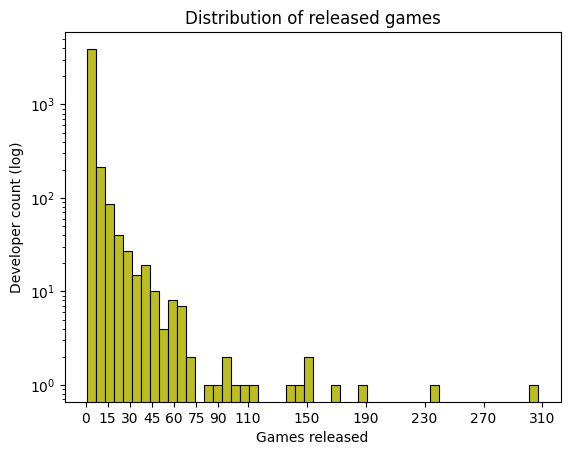

In [101]:
df_counts = prediction_df['developer'].value_counts().reset_index()
plt.hist(df_counts['count'], bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
plt.xticks(list(np.arange(0, 100, 15)) + list(np.arange(110, 350, 40)))
plt.yscale('log')
plt.xlabel("Games released")
plt.ylabel("Developer count (log)")
plt.title("Distribution of released games")
plt.show()

Видим, что разработчиков с малым количеством выпущенных игр очень много. Поэтому при использовании Count Encoder игры от этих разработчиков будут иметь заметно меньший вес. Сделаем следующее: выделим несколько групп студий по количеству выпущенных игр и запишем для них в столбец developer название группы.

In [102]:
prediction_df['count'] = prediction_df['developer'].map(prediction_df['developer'].value_counts())
prediction_df.loc[prediction_df['count'] <= 70, 'developer'] = 'other0'
prediction_df.loc[prediction_df['count'] <= 50, 'developer'] = 'other1'
prediction_df.loc[prediction_df['count'] <= 30, 'developer'] = 'other2'
prediction_df.loc[prediction_df['count'] <= 15, 'developer'] = 'other3'
prediction_df.loc[prediction_df['count'] <= 10, 'developer'] = 'other4'
prediction_df.loc[prediction_df['count'] <= 5, 'developer'] = 'other5'
prediction_df.loc[prediction_df['count'] <= 2, 'developer'] = 'other6'
prediction_df = prediction_df.drop(columns='count')

Теперь используем Count Encoder - каждое значение в столбце developer заменим на количество его вхождений. Благодаря проделанной подготовке мелкие студии также получат достаточно крупный вес в модели, что уменьшит не соответствующую реальности прямую зависимость между размером студии и рейтингом выпускаемых ею игр.

In [103]:
encoder = ce.CountEncoder(cols=['developer'])
prediction_df = encoder.fit_transform(prediction_df)

Подготовим столбец genre. Каждой игре соответствует несколько жанров, поэтому стандартные методы обработки категориальных признаков не дадут необходимой зависимости. Сделаем иначе. Для начала убедимся, что в каждой записи о жанрах нет повторяющихся названий.

In [104]:
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: list(set(x.split(', '))))

Теперь для каждого названия жанра подсчитаем количество раз, которое он встречается в датасете:

In [105]:
words = list(chain.from_iterable(prediction_df['genre']))
word_counts = Counter(words)

Заменим все списки столбца genre на среднее значение по подсчитанным выше количествам:

In [106]:
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: np.sqrt(np.mean(list(map(lambda y: word_counts[y], x)))))

Выведем полученный датасет:

In [107]:
prediction_df

,title,year,genre,developer,userscore,platform_DS,platform_Dreamcast,platform_Game Boy Advance,platform_GameCube,platform_Nintendo 64,...,platform_PlayStation 5,platform_PlayStation Vita,platform_Stadia,platform_Switch,platform_Wii,platform_Wii U,platform_Xbox,platform_Xbox 360,platform_Xbox One,platform_Xbox Series X
0,Burnout 3: Takedown,2004,36.837481,1944,77,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,Jet Grind Radio,2000,56.894639,2080,83,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Metal Gear Solid 4: Guns of the Patriots,2008,54.990908,2405,88,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tom Clancy's Splinter Cell Chaos Theory,2005,45.210618,148,91,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,Call of Duty: Modern Warfare 2,2009,52.314434,1944,66,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19312,Family Party: 30 Great Games Obstacle Arcade,2012,25.113078,3785,25,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
19313,Ride to Hell: Retribution,2013,40.003571,3785,14,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19314,Far Cry 5: Lost on Mars,2018,56.236109,148,45,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19315,Smash T.V.,2005,43.554563,1944,83,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


# Модель линейной регрессия

Сделаем копию обработанного датасета и выделим матрицу признаков и столбец таргетов:

In [108]:
X = prediction_df.copy()
X = X.drop(columns=['title', 'userscore']) # feature matrix
y = prediction_df['userscore'] # target column

Разделим датасет на обучающую и тестовую выборки:

In [109]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=25)

Проведем стандартизацию данных: удалим среднее и масштабируем дисперсию к единице.


In [259]:
scaler = sklp.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

-12.975528158545647
-0.1851324529376664


## Обычная модель

Обучим простую модель без регуляризации и посчитаем ошибки на обучающей и тестовой выборках:

In [111]:
model = sklm.LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Errors on test data:')

mae_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mae_test:.6f}")

mse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {mse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mae_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mae_train:.6f}")

mse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {mse_train:.6f}")

Errors on test data:
MAPE: 0.184625
RMSE: 12.956768
Errors on train data:
MAPE: 0.186871
RMSE: 12.952948


Ошибки на тестовых и обучающих данных почти не различаются. Это может говорить либо об очень высоком качестве модели, либо о том, что с данными что-то не так. Изобразим предсказанные данные:

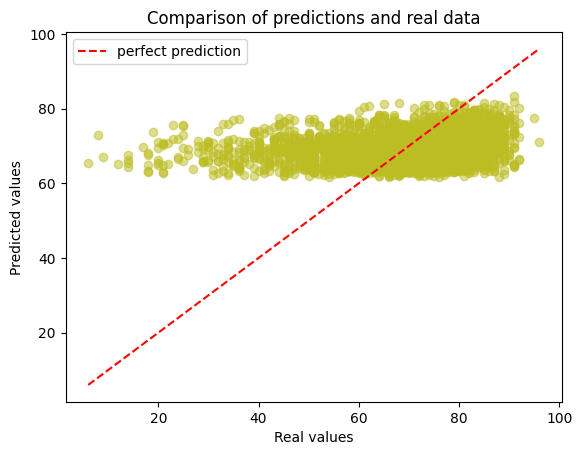

In [118]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Видим, что модель обучилась неправильно. Все её предсказания лежат в интервале $[60, 80]$. Посмотрим на распределение таргетов:

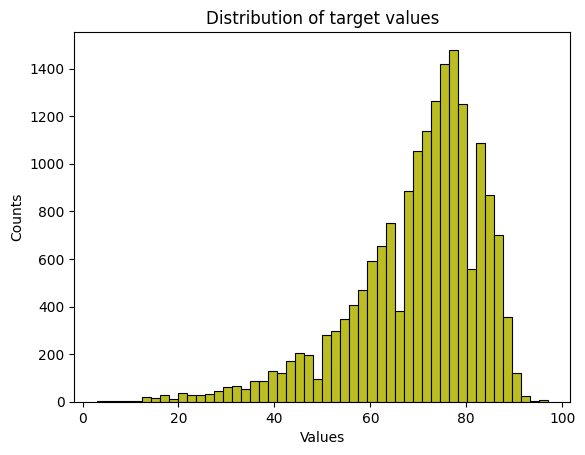

In [120]:
plt.hist(y, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
plt.xlabel("Values")
plt.ylabel("Counts")
plt.title("Distribution of target values")
plt.show()

Видим, что в данных имеется существенный перекос, то есть большинство игр имеют рейтинг в диапазоне от 60 до 80. Из-за этого модель обучается неправильно и не учится предсказывать значения в общем диапазоне. Как известно, линейная регрессия плохо работает с данными не нормального распределения. Попробуем воспользоваться инструментами библиотеки sklearn для преобразования данных.

## Модель с дополнительной трансформацией

Используем PowerTransformer, чтобы придать данным распределение, более близкое к нормальному:

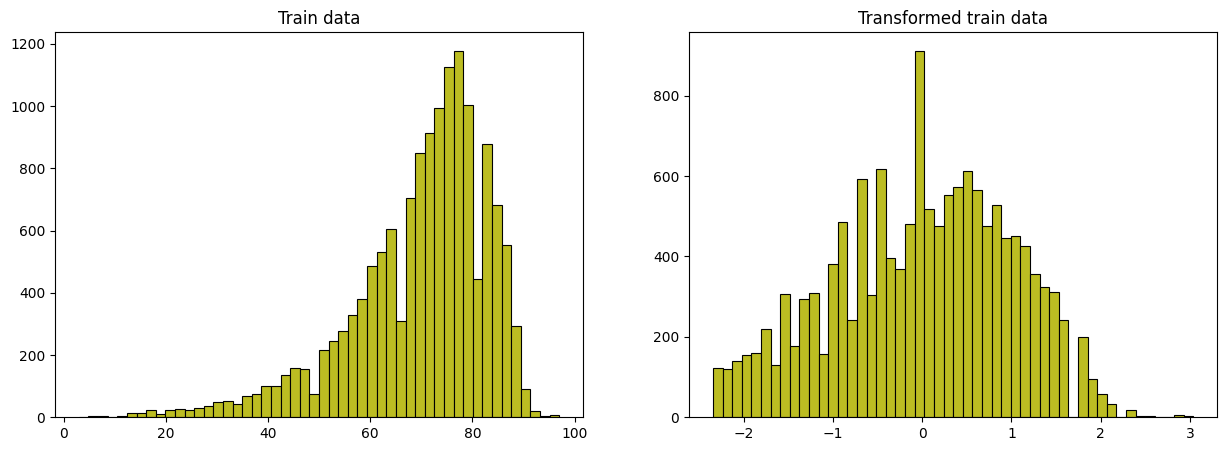

In [123]:
pt = sklp.PowerTransformer(method='box-cox', standardize=True)
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(y_train, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[0].set_title("Train data")
ax[1].hist(y_train_transformed, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[1].set_title("Transformed train data")
plt.show()

Обучим новую модель:

In [129]:
model_2 = sk.linear_model.LinearRegression()
model_2.fit(X_train, y_train_transformed)

y_pred_test_transformed = model_2.predict(X_test)
y_pred_test_transformed = pt.inverse_transform(y_pred_test_transformed.reshape(-1, 1))

mae = skmtr.mean_absolute_percentage_error(y_test, y_pred_test_transformed)
print(f"MAPE: {mae:.6f}")

mse = np.sqrt(skmtr.mean_squared_error(y_test, y_pred_test_transformed))
print(f"RMSE: {mse:.6f}")

y_pred_train_transformed = model_2.predict(X_train)
y_pred_train_transformed = pt.inverse_transform(y_pred_train_transformed.reshape(-1, 1))

mae = skmtr.mean_absolute_percentage_error(y_train, y_pred_train_transformed)
print(f"MAPE: {mae:.6f}")

mse = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train_transformed))
print(f"RMSE: {mse:.6f}")

MAPE: 0.185453
RMSE: 13.067858
MAPE: 0.188955
RMSE: 13.112538


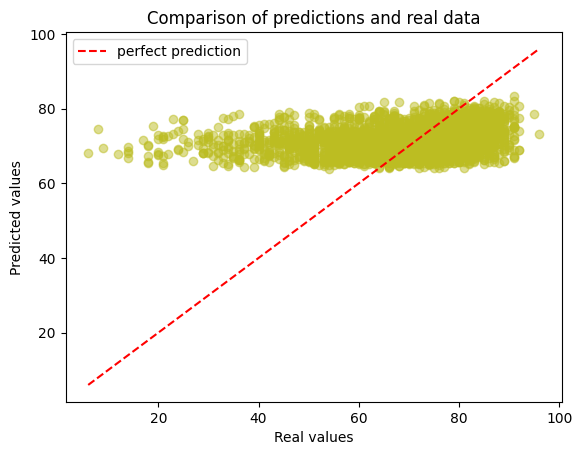

In [131]:
plt.scatter(y_test, y_pred_test_transformed, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Видим, что трансформация данных ничего не изменила, модель стала работать даже чуть хуже. Поэтому можно сделать окончательный вывод о том, что линейная регрессия не очень подходит для решения поставленной задачи ввиду особенностей данных.

## Ridge regression ??? (мне кажется лишнее)

In [205]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alpha_values = {'alpha': np.arange(1, 500, 5)}

ridge = GridSearchCV(Ridge(),
                     alpha_values,
                     scoring='neg_root_mean_squared_error',
                     cv=10)

print('Лучшее значение alpha:', ridge.fit(X_train, y_train).best_params_)

print('Метрика качества:', ridge.fit(X_train, y_train).best_score_)

Лучшее значение alpha: {'alpha': 311}
Метрика качества: -12.959860761855825


In [206]:
ridge_model = Ridge(alpha=311)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = skms.cross_val_score(ridge_model, X_test, y_test, scoring='neg_root_mean_squared_error', cv=15)
print(mse.mean())

mse = skms.cross_val_score(ridge_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error', cv=15)
print(mse.mean())

mae = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mae:.6f}")

mse = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {mse:.6f}")

r2 = skmtr.r2_score(y_test, y_pred)
print(f"R²: {r2:.6f}")

y_pred = model.predict(X_train)

mae = skmtr.mean_absolute_percentage_error(y_train, y_pred)
print(f"MAPE: {mae:.6f}")

mse = np.sqrt(skmtr.mean_squared_error(y_train, y_pred))
print(f"RMSE: {mse:.6f}")

-12.969324257993799
-0.18523231633942902
MAPE: 0.184372
RMSE: 12.929543
R²: 0.077855
MAPE: 0.186611
RMSE: 12.941245


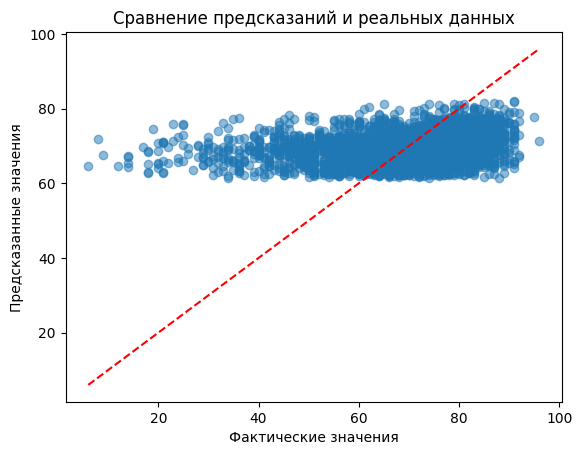

In [208]:
y_pred = ridge_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказаний и реальных данных")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

In [105]:
X.corr().style.background_gradient(cmap = 'coolwarm')

,year,genre,developer,platform_DS,platform_Dreamcast,platform_Game Boy Advance,platform_GameCube,platform_Nintendo 64,platform_PC,platform_PSP,platform_PlayStation,platform_PlayStation 2,platform_PlayStation 3,platform_PlayStation 4,platform_PlayStation 5,platform_PlayStation Vita,platform_Stadia,platform_Switch,platform_Wii,platform_Wii U,platform_Xbox,platform_Xbox 360,platform_Xbox One,platform_Xbox Series X
year,1.000000,0.130303,0.205326,-0.110042,-0.147762,-0.186303,-0.200409,-0.125973,0.051743,-0.102933,-0.181350,-0.334482,-0.044650,0.329831,0.152350,0.044697,0.017728,0.341109,-0.085268,0.038253,-0.244711,-0.084826,0.232969,0.124444
genre,0.130303,1.000000,0.090175,-0.002830,-0.003952,0.012277,-0.031288,0.005045,-0.017503,-0.025931,-0.009621,-0.080507,0.007322,0.053738,-0.000997,0.016931,0.020796,0.041271,0.004002,0.032511,-0.052898,0.008469,0.033862,-0.007386
developer,0.205326,0.090175,1.000000,-0.014232,-0.017045,-0.006626,-0.072582,-0.005281,0.155961,-0.033059,-0.023927,-0.100063,-0.095068,0.038369,-0.004899,-0.002132,-0.000665,0.142322,-0.048570,-0.000379,-0.061552,-0.088671,0.017176,-0.003240
platform_DS,-0.110042,-0.002830,-0.014232,1.000000,-0.015242,-0.025678,-0.028485,-0.011611,-0.111864,-0.030047,-0.017747,-0.051657,-0.049888,-0.065083,-0.018335,-0.022118,-0.002382,-0.051699,-0.034412,-0.018802,-0.036394,-0.057522,-0.047055,-0.014860
platform_Dreamcast,-0.147762,-0.003952,-0.017045,-0.015242,1.000000,-0.011543,-0.012804,-0.005219,-0.050283,-0.013506,-0.007977,-0.023220,-0.022425,-0.029255,-0.008241,-0.009942,-0.001071,-0.023239,-0.015468,-0.008452,-0.016359,-0.025856,-0.021152,-0.006680
platform_Game Boy Advance,-0.186303,0.012277,-0.006626,-0.025678,-0.011543,1.000000,-0.021572,-0.008793,-0.084714,-0.022755,-0.013440,-0.039119,-0.037780,-0.049287,-0.013885,-0.016750,-0.001804,-0.039152,-0.026060,-0.014239,-0.027561,-0.043561,-0.035635,-0.011253
platform_GameCube,-0.200409,-0.031288,-0.072582,-0.028485,-0.012804,-0.021572,1.000000,-0.009754,-0.093973,-0.025242,-0.014909,-0.043395,-0.041909,-0.054674,-0.015402,-0.018581,-0.002001,-0.043431,-0.028908,-0.015795,-0.030573,-0.048322,-0.039529,-0.012483
platform_Nintendo 64,-0.125973,0.005045,-0.005281,-0.011611,-0.005219,-0.008793,-0.009754,1.000000,-0.038305,-0.010289,-0.006077,-0.017688,-0.017083,-0.022286,-0.006278,-0.007574,-0.000816,-0.017703,-0.011783,-0.006438,-0.012462,-0.019697,-0.016113,-0.005088
platform_PC,0.051743,-0.017503,0.155961,-0.111864,-0.050283,-0.084714,-0.093973,-0.038305,1.000000,-0.099127,-0.058548,-0.170418,-0.164584,-0.214713,-0.060487,-0.072970,-0.007859,-0.170558,-0.113525,-0.062030,-0.120064,-0.189768,-0.155237,-0.049023
platform_PSP,-0.102933,-0.025931,-0.033059,-0.030047,-0.013506,-0.022755,-0.025242,-0.010289,-0.099127,1.000000,-0.015726,-0.045775,-0.044208,-0.057673,-0.016247,-0.019600,-0.002111,-0.045813,-0.030494,-0.016662,-0.032250,-0.050973,-0.041698,-0.013168
